# Read the files

In [1]:
library("tidyverse")
library("janitor")
library("caret")
library("mlr")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift

Loading required package: ParamHelpers

Attaching package: ‘mlr’

The following object is masked from ‘package:caret’:

    train



In [2]:
df_train = readRDS("df_train_after_03FE.RData")
df_val = readRDS("df_val_after_03FE.RData")
cols_with_low_iv_values = readRDS("cols_with_low_iv_values.RData")
cols_with_woe_added = readRDS("cols_with_woe_added.RData")

In [3]:
head(df_train,2)

t_mo,t_day,t_qtr,t_wk,t_day_of_yr,t_day_of_wk,t_day_of_wk_name,t_eval_day,t_eval_wk,trap_trap_name,⋯,woe_t_qtr,woe_t_day_of_wk_name,woe_trap_trap_name,woe_loc_zipcode,woe_loc_census_block_group_id,woe_loc_census_tract_id,woe_loc_community,woe_zone_class,woe_mos_species,dist_ohare
May,29,Q2,22,149,2,Mon,514,74,T002,⋯,-3.641826,-0.1034607,0.5805781,0.3444538,0.5805781,0.5805781,0.3531614,0.2058406,-0.08159657,424.2286
May,29,Q2,22,149,2,Mon,514,74,T002,⋯,-3.641826,-0.1034607,0.5805781,0.3444538,0.5805781,0.5805781,0.3531614,0.2058406,-0.15335105,424.2286


In [4]:
dim(df_train)

[1] 15257    68

In [8]:
cols_with_low_iv_values %>% cat(sep = " \n ")

nbrhud_comm_180d_violation_cnt 
 zone_type 
 mos_species 
 ses_lt_hs_pct_tract2017 
 loc_lat_lng_src 
 nbrhud_blk_grp_180d_violation_cnt 
 nbrhud_zipcode_180d_violation_cnt 
 t_day_of_yr 
 trap_trap_type 
 mos_salinarius_num_mosquitos 
 mos_unspecified_num_mosquitos 
 mos_erraticus_num_mosquitos 
 mos_tarsalis_num_mosquitos 
 trap_satellite_ind 
 t_day 
 mos_territans_num_mosquitos 
 nbrhud_comm_180d_vacancies_cnt 
 wea_ohare_tavg2_ma7 
 nbrhud_blk_grp_180d_vacancies_cnt 
 nbrhud_zipcode_180d_vacancies_cnt 
 wea_ohare_prcp 
 googtrend_deadbirds


# Little cleanup

In [9]:
# Remove cols_with_low_iv_values to make life a bit simplier

#df_train = df_train %>% select(-cols_with_low_iv_values)
#df_val = df_val %>% select(-cols_with_low_iv_values)

In [22]:
df_train = df_train %>% 
    rename(y=mos_any_wnv_present) %>%
    mutate(y = factor(y,levels = c(0,1), labels = c("Clean","Infected")))
df_val = df_val %>% 
    rename(y=mos_any_wnv_present) %>%
    mutate(y = factor(y,levels = c(0,1), labels = c("Clean","Infected")))

## Remove NA rows from val set

In [69]:
df_val = df_val[complete.cases(df_val),]

In [26]:
make_resp_first_var = function(df){
    pred_cols = names(df %>% select(-y))
    df %>% select(y, pred_cols)
}

In [28]:
df_train = df_train %>% make_resp_first_var
df_val   = df_val   %>% make_resp_first_var

In [29]:
dim(df_train)

[1] 15257    68

In [30]:
dim(df_val)

[1] 5991   68

In [31]:
glimpse(df_train)

Observations: 15,257
Variables: 68
$ y                                  <fct> Clean, Clean, Clean, Clean, Clea...
$ t_mo                               <fct> May, May, May, May, May, May, Ma...
$ t_day                              <int> 29, 29, 29, 29, 29, 29, 29, 29, ...
$ t_qtr                              <fct> Q2, Q2, Q2, Q2, Q2, Q2, Q2, Q2, ...
$ t_wk                               <int> 22, 22, 22, 22, 22, 22, 22, 22, ...
$ t_day_of_yr                        <int> 149, 149, 149, 149, 149, 149, 14...
$ t_day_of_wk                        <int> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,...
$ t_day_of_wk_name                   <fct> Mon, Mon, Mon, Mon, Mon, Mon, Mo...
$ t_eval_day                         <int> 514, 514, 514, 514, 514, 514, 51...
$ t_eval_wk                          <int> 74, 74, 74, 74, 74, 74, 74, 74, ...
$ trap_trap_name                     <fct> T002, T002, T007, T015, T015, T0...
$ loc_lat                            <dbl> 41.95630, 41.95630, 41.99549, 41...
$ loc_lng        

In [35]:
predictors = df_train %>% select(-y) %>% names

# Model Setup

## Random Forest

In [33]:
library("randomForest")

In [70]:
rfFit = randomForest(x = df_train %>%
                         select(predictors) %>%
                         select(-loc_census_block_group_id,
                                -loc_census_tract_id,
                                -loc_community,
                                -trap_trap_name),
                     y = df_train[[1]],
                     importance=TRUE,
                     xtest = df_val %>%
                         select(predictors) %>%
                         select(-loc_census_block_group_id,
                                -loc_census_tract_id,
                                -loc_community,
                                -trap_trap_name),
                     ytest = df_val[[1]],
                     ntrees = 150)

ERROR: Error in randomForest.default(x = df_train %>% select(predictors) %>% : New factor levels in xtest not present in x


In [61]:
rfFit


Call:
 randomForest(x = df_train %>% select(predictors) %>% select(-loc_census_block_group_id,      -loc_census_tract_id, -loc_community, -trap_trap_name), y = df_train[[1]],      importance = TRUE, test = df_val) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 7

        OOB estimate of  error rate: 1.02%
Confusion matrix:
         Clean Infected class.error
Clean    13450       26 0.001929356
Infected   130     1651 0.072992701

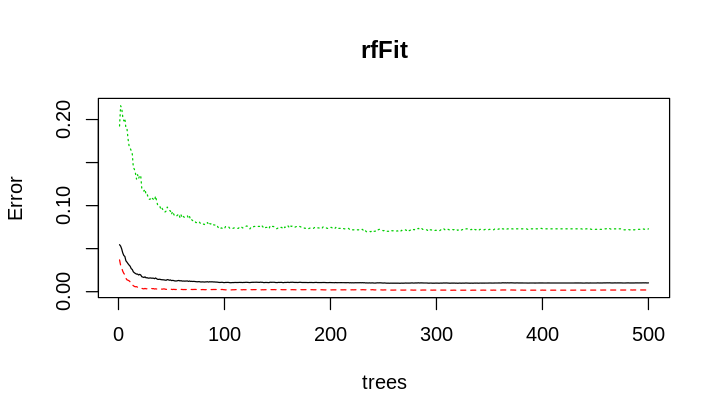

In [62]:
options(repr.plot.width=6, repr.plot.height=3.5)
plot(rfFit)

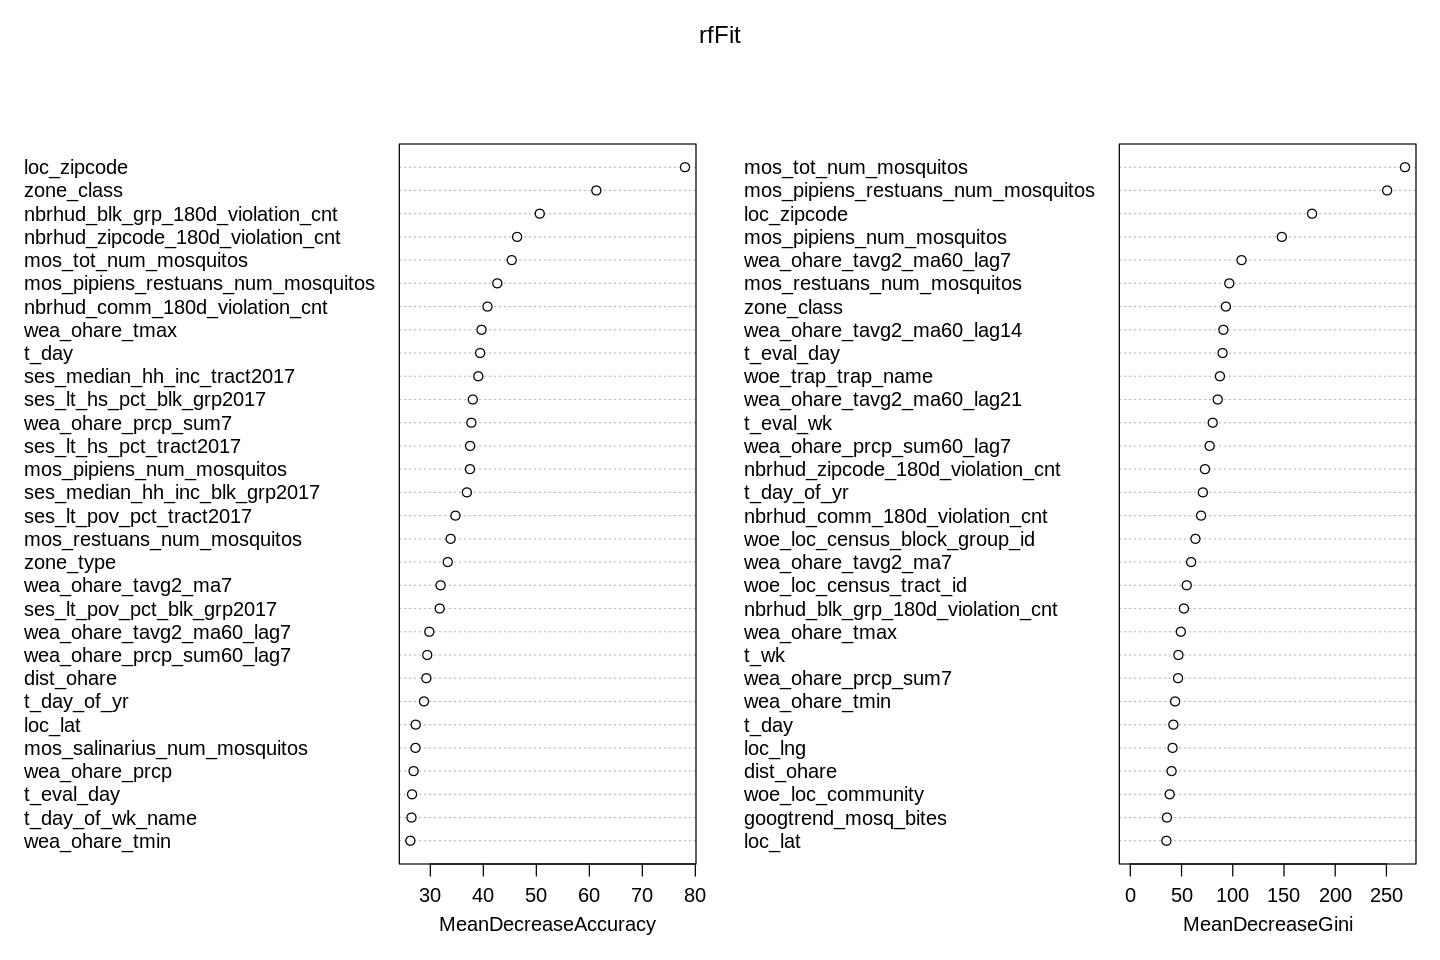

In [63]:
options(repr.plot.width=12, repr.plot.height=8)
randomForest::varImpPlot(rfFit)

## XG Boost

In [ ]:
library("xgboost")

In [ ]:
xgbFit = xgboost(data = as.matrix(df_train[,predictors]), label = as.numeric(df_train[[response]]), nrounds = 300, verbose = T,callbacks = )

In [ ]:
xgbFit

In [ ]:
xgboost::xgb.importance(xgbFit)

In [ ]:
xgb.ggplot.deepness(model = xgbFit)

In [ ]:
?xgboost